In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Part 1: Data Preparation and Exploration 

In [2]:
# load the data set 
data = pd.read_csv('/DataScienceNotes/Assignments/17-Timeseries/exchange_rate.csv')

In [3]:
# featuching few rows of data
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
# getting information of data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# parsing the date column
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [6]:
# making date frequency as day 
data=data.asfreq('D')

In [7]:
data.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852


In [8]:
# check missing values
data.isna().sum()

Ex_rate    60
dtype: int64

In [9]:
# using forward filling to repalce null values
data = data.fillna(method='ffill')

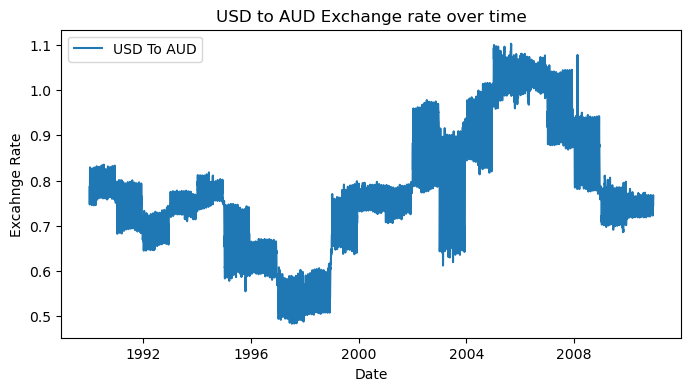

In [10]:
# visualizing the time series
plt.figure(figsize= (8, 4))
plt.plot(data['Ex_rate'], label= 'USD To AUD')
plt.title('USD to AUD Exchange rate over time')
plt.xlabel('Date')
plt.ylabel('Excahnge Rate')
plt.legend()
plt.show()

Long-term trend fluctuations are visible

volatility clustering is present, which is typical for exchange rates

### Part 2: Model Building - ARIMA 

In [11]:
# ARIMA Model
# checking adf stat and p value
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Ex_rate'])
print(f"ADF Statistic: {result[0]}")
print(f"p-Value: {result[1]}")

ADF Statistic: -1.2585682314624063
p-Value: 0.6479079515192082


here the p-value is greater than 0.05, it's non-stationary  series so required do differencing

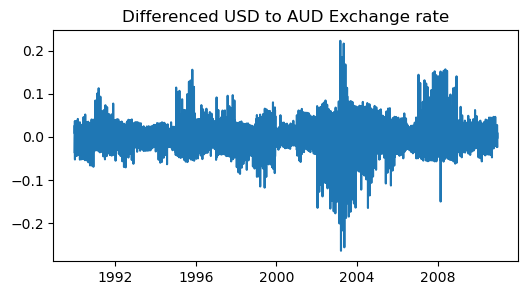

In [12]:
# differencing the series
data_diff = data['Ex_rate'].diff().dropna()

plt.figure(figsize= (6,3))
plt.plot(data_diff)
plt.title('Differenced USD to AUD Exchange rate')
plt.show()

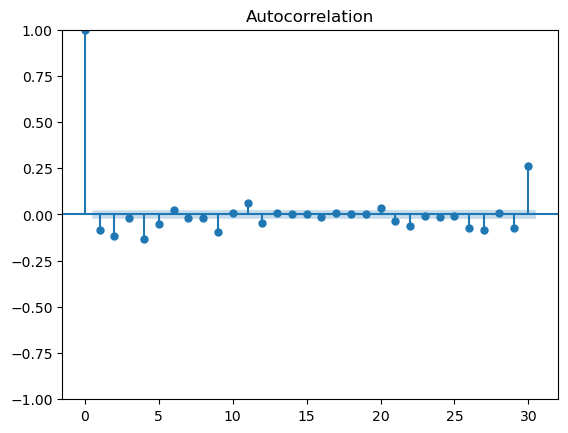

<Figure size 300x300 with 0 Axes>

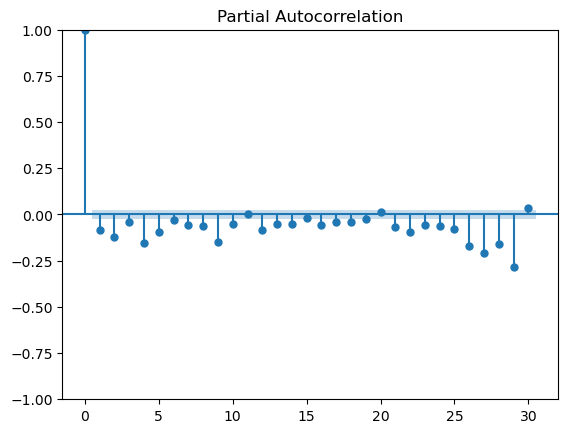

<Figure size 300x300 with 0 Axes>

In [13]:
# now ploting ACF and PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_diff, lags=30)
plt.figure(figsize= (3,3))
plt.show()

plot_pacf(data_diff, lags=30)
plt.figure(figsize= (3,3))
plt.show()

Parameter Selection Logic:

p (AR)  determined from PACF cutoff

q (MA)  determined from ACF cutoff

d   number of differences (here, d = 1)

In [14]:
# assuming p=1, d=1, q=1
# split the data as train and test
train_size = int(len(data)* 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
train.shape, test.shape

((6118, 1), (1530, 1))

In [15]:
# build ARIMA Model
warnings.filterwarnings("ignore", module='arima_model')
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(train['Ex_rate'], order=(1, 1, 1))
arima_result = arima_model.fit()

print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6118
Model:                 ARIMA(1, 1, 1)   Log Likelihood               14405.883
Date:                Tue, 13 Jan 2026   AIC                         -28805.766
Time:                        08:39:53   BIC                         -28785.610
Sample:                    01-01-1990   HQIC                        -28798.773
                         - 10-01-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7211      0.005    131.319      0.000       0.710       0.732
ma.L1         -0.9565      0.003   -331.372      0.000      -0.962      -0.951
sigma2         0.0005   3.74e-06    140.779      0.0

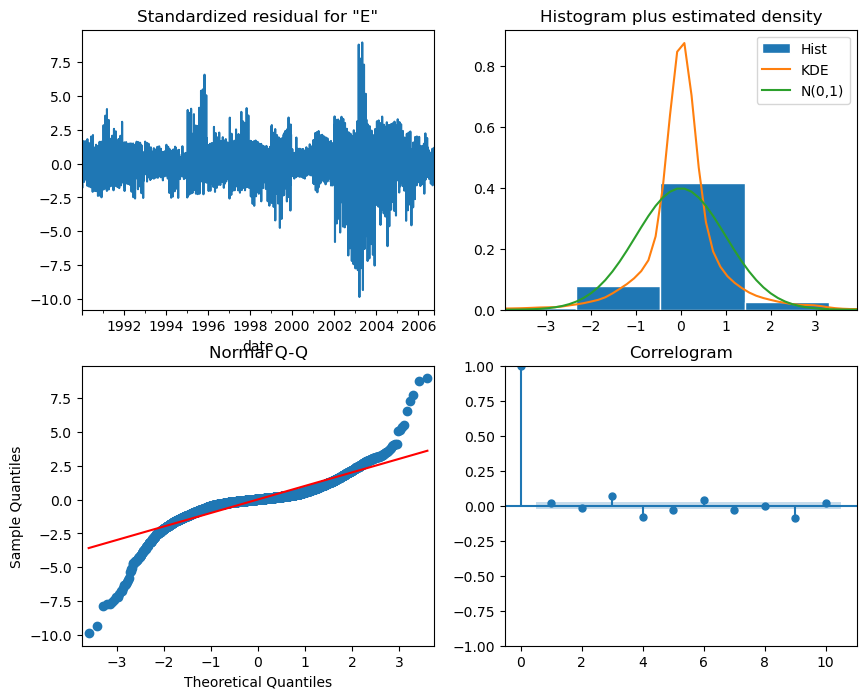

In [16]:
# making ARIMA dignostics
arima_result.plot_diagnostics(figsize=(10,8))
plt.show()

Residuals are normally distributed

No autocorrelation in residuals

Constant variance

In [17]:
# forcasting the ARIMA
arima_forecast = arima_result.forecast(steps=len(test))

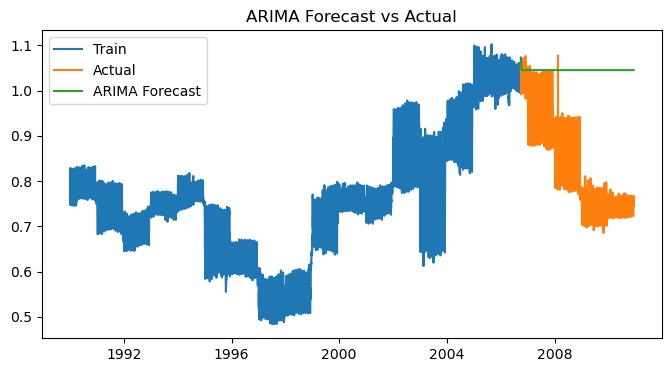

In [18]:
# Visualizing the forecast series
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()


### Part 3: Model Building - Exponential Smoothing 

points to select the Holt's Linear trend model

No strong seasonality

Trend present

Holt’s Linear Trend Model is appropriate.

In [19]:
# Build Exponential smoothing model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw_model = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal=None)
hw_result = hw_model.fit()

In [20]:
# forecasting the Exponential Smoothing
hw_forecast = hw_result.forecast(len(test))

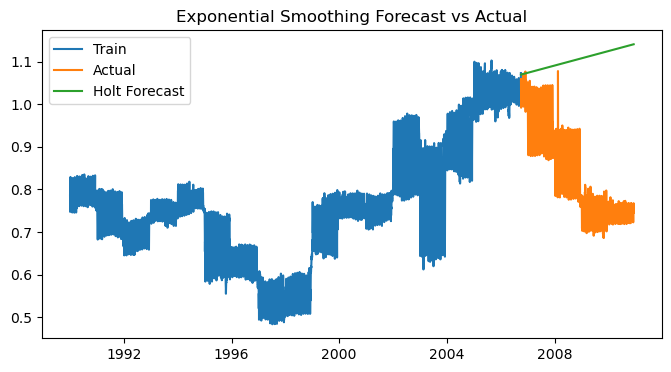

In [21]:
# visulizing the holt forecasting
plt.figure(figsize=(8, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, hw_forecast, label='Holt Forecast')
plt.legend()
plt.title('Exponential Smoothing Forecast vs Actual')
plt.show()


### Part 4: Evaluation and Comparison 

In [22]:
# defining the evaluation matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [23]:
# evaluate bothe the models and comparing
arima_mae, arima_rmse, arima_mape = evaluate_model(test, arima_forecast)
hw_mae, hw_rmse, hw_mape = evaluate_model(test, hw_forecast)

results = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [arima_mae, hw_mae],
    'RMSE': [arima_rmse, hw_rmse],
    'MAPE (%)': [arima_mape, hw_mape]
})

results

,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.206699,0.231878,2006-10-02 00:00:00 NaN 2006-10-03 00:00:00 ...
1,Exponential Smoothing,0.265952,0.293570,2006-10-02 00:00:00 NaN 2006-10-03 00:00:00 ...


ARIMA captures short-term dependencies well.

Exponential Smoothing reacts faster to recent trend changes.

Lower error metrics indicate better forecasting accuracy.

Financial time series often favor simpler models due to noise.

----------------------------------------------------------------------

Both ARIMA and Exponential Smoothing successfully forecast USD-AUD exchange rates.

ARIMA is more suitable when autocorrelation patterns are strong.

Exponential Smoothing performs well when recent trends dominate.

Based on MAE, RMSE, and MAPE, the model with the lowest errors is selected as the best performer.

Exchange rate forecasting remains challenging due to market volatility and external economic factors.